In [3]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)
import numpy as np
from sim_utils.modeling import create_model, create_reg_model, update_config
from utils.quack import Quack

In [ ]:
"""rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,
	case when pbp.run_gap = 'end' then 2
		when pbp.run_gap = 'tackle' then 1
		when pbp.run_gap = 'guard' then 0  else 1 end as run_gap_encoded,
	case when pbp.down = 1 then '1' else 0 end as is_first_down,
	case when pbp.down = 2 then '1' else 0 end as is_second_down,
	case when pbp.down = 3 then '1' else 0 end as is_third_down,
	case when pbp.down = 4 then '1' else 0 end as is_fourth_down,
                     pbp.first_down, pbp.touchdown,
	{', '.join(('pbp.' + x for x in game_context_cols))},
	{', '.join(('t.' + x for x in team_stat_cols))},
	{', '.join(('o.' + x for x in opp_stat_cols))},
	{', '.join(('r.' + x for x in rusher_stat_cols))},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.rusher_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
    and pbp.penalty = 0
    and pbp.fumble = 0
""")
"""

In [ ]:
Quack.query('select * from pbp where season > 2021')

,season
0,2000
1,2000
2,2000
3,2000
4,2000
...,...
95,2000
96,2000
97,2000
98,2000


In [6]:

pbp = Quack.query('select * from pbp where season > 2021')
small = pbp.loc[pbp.season > 2021].dropna(how="all", axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'out_of_bounds', 'home_opening_kickoff', 'qb_epa', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd',
       'xpass', 'pass_oe'],
      dtype='object', length=372)


In [7]:
desc_cols = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "game_half",
    "posteam",
    "side_of_field",
    "desc",
]


In [8]:
play_type_mapping = {
    "field_goal": 0,
    "no_play": 1,
    "pass": 2,
    "punt": 3,
    "qb_kneel": 4,
    "qb_spike": 5,
    "run": 6,
    np.nan: 7,
}

In [9]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    # "yards_gained",
    "posteam_score",
    # "total_away_score",
    "score_differential",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
]

pbp["play_type_enc"] = pbp["play_type"].map(play_type_mapping)
y_col = "play_type_enc"
data = pbp.loc[
    (~pbp.down.isna()) & (~pbp.rush_attempt.isna()) & ~(pbp.play_type.isna())
][game_context_cols + [y_col]]

In [10]:
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
receiver_cols = [x for x in team_receiver_stats.columns if "ception" in x] + [
    x for x in team_receiver_stats.columns if "arget" in x
] + [x for x in team_receiver_stats.columns if "ppr" in x] + [
    x for x in team_receiver_stats.columns if "pct" in x] + [
        x for x in team_receiver_stats.columns if "per_catch" in x
    ]
sorted(receiver_cols)

['fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_TE_1',
 'fantasy_points_ppr_roll_TE_2',
 'fantasy_points_ppr_roll_WR_0',
 'fantasy_points_ppr_roll_WR_1',
 'fantasy_points_ppr_roll_WR_2',
 'fantasy_points_ppr_roll_WR_3',
 'fantasy_points_ppr_roll_WR_4',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_TE_1',
 'offense_pct_roll_TE_2',
 'offense_pct_roll_WR_0',
 'offense_pct_roll_WR_1',
 'offense_pct_roll_WR_2',
 'offense_pct_roll_WR_3',
 'offense_pct_roll_WR_4',
 'receptions_roll_RB_0',
 'receptions_roll_RB_1',
 'receptions_roll_TE_0',
 'receptions_roll_TE_1',
 'receptions_roll_TE_2',
 'receptions_roll_WR_0',
 'receptions_roll_WR_1',
 'receptions_roll_WR_2',
 'receptions_roll_WR_3',
 'receptions_roll_WR_4',
 'target_share_roll_RB_0',
 'target_share_roll_RB_1',
 'target_share_roll_TE_0',
 'target_share_roll_TE_1',
 'target_share_roll_TE_2',
 'target_share_roll_WR_0'

In [11]:
team_receiver_stats

,team,season,week,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_4,player_display_name_WR_2,player_display_name_WR_3,...,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0,offense_snaps_roll_RB_1,offense_snaps_roll_RB_0,offense_pct_roll_RB_1,offense_pct_roll_RB_0,yards_per_catch_roll_RB_1,yards_per_catch_roll_RB_0,yards_per_target_roll_RB_1,yards_per_target_roll_RB_0
0,ARI,2013,1,00-0027691,00-0030300,00-0022921,00-0029638,NaN,Andre Roberts,Jaron Brown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARI,2013,2,00-0027691,00-0030300,00-0022921,00-0029638,NaN,Andre Roberts,Jaron Brown,...,NaN,7.400000,NaN,35.000000,NaN,0.490000,NaN,4.000000,NaN,5.500000
2,ARI,2013,3,00-0030300,00-0027691,00-0029638,00-0022921,NaN,Jaron Brown,Andre Roberts,...,9.100000,13.114286,13.714286,35.571429,0.190000,0.501429,13.055556,8.444444,10.666667,9.611111
3,ARI,2013,4,00-0030300,00-0027691,00-0029638,00-0022921,NaN,Jaron Brown,Andre Roberts,...,8.840541,9.648649,19.459459,30.135135,0.311081,0.457568,11.398305,8.279070,7.913043,9.569767
4,ARI,2013,5,00-0027691,NaN,00-0029638,00-0022921,NaN,Andre Roberts,NaN,...,3.582857,7.729143,13.331429,34.108571,0.204000,0.531600,4.694981,6.272374,4.974286,6.486159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,WAS,2024,20,00-0035659,NaN,00-0036626,NaN,00-0035208,Terry McLaurin,NaN,...,2.882656,7.799894,17.137838,36.331038,0.232920,0.505221,3.435670,5.526417,4.208944,5.713621
5744,WAS,2024,21,00-0036626,00-0035208,00-0035659,00-0039355,NaN,Dyami Brown,Olamide Zaccheaus,...,3.861995,10.774943,16.103375,37.248285,0.217190,0.511416,3.512705,5.381450,4.545143,5.822707
5745,WAS,2025,1,00-0033591,00-0039355,00-0035659,00-0035719,00-0040164,Noah Brown,Luke McCaffrey,...,NaN,11.648473,NaN,38.170744,NaN,0.571567,NaN,7.779501,NaN,7.061687
5746,WAS,2025,2,00-0033591,00-0040164,00-0035659,00-0035719,00-0039355,Noah Brown,Jaylin Lane,...,14.200000,10.911355,23.000000,36.878058,0.330000,0.546175,4.000000,8.008858,3.500000,7.561498


In [12]:
team_rusher_cols = ['carries_roll_QB_0',
 'carries_roll_QB_1',
 'carries_roll_RB_0',
 'carries_roll_RB_1',
 'carries_roll_RB_2',
 'carries_roll_TE_0',
 'carries_roll_WR_0',
 'fantasy_points_ppr_roll_QB_0',
 'fantasy_points_ppr_roll_QB_1',
 'fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_RB_2',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_WR_0',
 'yards_per_carry_roll_QB_0',
 'yards_per_carry_roll_QB_1',
 'yards_per_carry_roll_RB_0',
 'yards_per_carry_roll_RB_1',
 'yards_per_carry_roll_RB_2',
 'yards_per_carry_roll_TE_0',
 'yards_per_carry_roll_WR_0',
 'offense_pct_roll_QB_0',
 'offense_pct_roll_QB_1',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_RB_2',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_WR_0',
 'rushing_first_downs_roll_QB_0',
 'rushing_first_downs_roll_QB_1',
 'rushing_first_downs_roll_RB_0',
 'rushing_first_downs_roll_RB_1',
 'rushing_first_downs_roll_RB_2',
 'rushing_first_downs_roll_TE_0',
 'rushing_first_downs_roll_WR_0',
 'rushing_tds_roll_QB_0',
 'rushing_tds_roll_QB_1',
 'rushing_tds_roll_RB_0',
 'rushing_tds_roll_RB_1',
 'rushing_tds_roll_RB_2',
 'rushing_tds_roll_TE_0',
 'rushing_tds_roll_WR_0',
 'rushing_yards_roll_QB_0',
 'rushing_yards_roll_QB_1',
 'rushing_yards_roll_RB_0',
 'rushing_yards_roll_RB_1',
 'rushing_yards_roll_RB_2',
 'rushing_yards_roll_TE_0',
 'rushing_yards_roll_WR_0',
 'last_rusher_drive',
 'last_rusher_team']

In [13]:
def get_rusher_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    ):
        if row[col_name] == row["rusher_player_id"]:
            return num
    return None

In [14]:
team_rb_stats = pd.read_csv("data/team_rushers.csv", index_col=0)
comb = pbp.merge(
    team_rb_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team", "season", "week"],
)

comb["rusher_depth_num"] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(
    deep=True
)
rushes["last_rusher_drive"] = (
    rushes.groupby(["game_id", "drive", "posteam"])["rusher_depth_num"]
    .shift()
    .fillna(-1)
)
rushes["last_rusher_team"] = (
    rushes.groupby(["game_id", "posteam"])["rusher_depth_num"].shift().fillna(-1)
)
rushes[(game_context_cols + team_rusher_cols)]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,rushing_tds_roll_WR_0,rushing_yards_roll_QB_0,rushing_yards_roll_QB_1,rushing_yards_roll_RB_0,rushing_yards_roll_RB_1,rushing_yards_roll_RB_2,rushing_yards_roll_TE_0,rushing_yards_roll_WR_0,last_rusher_drive,last_rusher_team
2,64.0,3.0,0.0,2.0,0.0,0.0,761.0,1661.0,3461.0,NaN,...,0.000000,50.921357,0.0,30.378973,NaN,3.996020,0.000000,3.130803e+00,-1.0,-1.0
8,66.0,2.0,0.0,10.0,0.0,0.0,422.0,1322.0,3122.0,NaN,...,0.000000,50.921357,0.0,30.378973,NaN,3.996020,0.000000,3.130803e+00,-1.0,3.0
33,75.0,1.0,0.0,10.0,10.0,7.0,24.0,24.0,1824.0,NaN,...,0.000000,50.921357,0.0,30.378973,NaN,3.996020,0.000000,3.130803e+00,-1.0,0.0
37,73.0,3.0,0.0,8.0,10.0,7.0,855.0,1755.0,1755.0,NaN,...,0.000000,50.921357,0.0,30.378973,NaN,3.996020,0.000000,3.130803e+00,-1.0,2.0
38,65.0,1.0,0.0,10.0,10.0,7.0,814.0,1714.0,1714.0,NaN,...,0.000000,50.921357,0.0,30.378973,NaN,3.996020,0.000000,3.130803e+00,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104887,25.0,3.0,0.0,2.0,14.0,0.0,240.0,240.0,240.0,NaN,...,0.000000,4.221979,0.0,35.948494,14.930717,NaN,0.000663,4.778409e-07,3.0,3.0
104888,21.0,1.0,0.0,10.0,14.0,0.0,195.0,195.0,195.0,NaN,...,0.000000,4.221979,0.0,35.948494,14.930717,NaN,0.000663,4.778409e-07,0.0,0.0
104897,52.0,2.0,0.0,2.0,14.0,-7.0,99.0,99.0,99.0,NaN,...,0.044495,23.570031,0.0,41.473646,17.285714,29.459334,0.000000,-8.449048e-02,-1.0,3.0
104902,71.0,1.0,0.0,10.0,21.0,7.0,63.0,63.0,63.0,NaN,...,0.000000,4.221979,0.0,35.948494,14.930717,NaN,0.000663,4.778409e-07,-1.0,0.0


In [15]:
rushes[['posteam','game_id', 'last_rusher_team', 'rusher_depth_num']].head(20)

,posteam,game_id,last_rusher_team,rusher_depth_num
2,BAL,2022_01_BAL_NYJ,-1.0,3.0
8,BAL,2022_01_BAL_NYJ,3.0,0.0
33,BAL,2022_01_BAL_NYJ,0.0,2.0
37,BAL,2022_01_BAL_NYJ,2.0,3.0
38,BAL,2022_01_BAL_NYJ,3.0,2.0
43,BAL,2022_01_BAL_NYJ,2.0,3.0
46,BAL,2022_01_BAL_NYJ,3.0,3.0
52,BAL,2022_01_BAL_NYJ,3.0,0.0
68,BAL,2022_01_BAL_NYJ,0.0,3.0
69,BAL,2022_01_BAL_NYJ,3.0,3.0


In [16]:
comb.loc[comb.rusher_player_name=='J.Hurts'][['home_team','season','week','rusher_player_id','rusher_depth_num', 'gsis_id_QB_0',
                                              'gsis_id_QB_1','desc']]

,home_team,season,week,rusher_player_id,rusher_depth_num,gsis_id_QB_0,gsis_id_QB_1,desc
1583,DET,2022,1,00-0036389,3.0,00-0036389,0,(10:18) (Shotgun) 1-J.Hurts left end pushed ob...
1584,DET,2022,1,00-0036389,3.0,00-0036389,0,(9:35) (Shotgun) 1-J.Hurts scrambles up the mi...
1588,DET,2022,1,00-0036389,3.0,00-0036389,0,(8:42) (Shotgun) 1-J.Hurts scrambles up the mi...
1601,DET,2022,1,00-0036389,3.0,00-0036389,0,(4:17) (Shotgun) 1-J.Hurts scrambles left end ...
1603,DET,2022,1,00-0036389,3.0,00-0036389,0,(2:49) (Shotgun) 1-J.Hurts scrambles left end ...
...,...,...,...,...,...,...,...,...
104177,PHI,2025,3,00-0036389,3.0,00-0036389,0,(:10) 1-J.Hurts kneels to PHI 34 for -1 yards.
104208,PHI,2025,3,00-0036389,3.0,00-0036389,0,(3:47) 1-J.Hurts up the middle to LA 10 for 1 ...
104236,PHI,2025,3,00-0036389,3.0,00-0036389,0,"(7:54) (No Huddle, Shotgun) 1-J.Hurts left end..."
104243,PHI,2025,3,00-0036389,3.0,00-0036389,0,"(4:40) (No Huddle, Shotgun) 1-J.Hurts left tac..."


In [17]:
rushes['rushing_yards_roll_RB_0'].max()

np.float64(150.4002485696573)

In [18]:
choose_rusher_cols = (
    game_context_cols + team_rusher_cols
)
choose_rusher_model = create_model(
    rushes.fillna(0), x_cols=choose_rusher_cols, y_col="rusher_depth_num"
)
joblib.dump(choose_rusher_model, "models/choose_rusher.joblib")
_ = """
Accuracy: 0.69
Confusion Matrix:
array([[17449,  1485,   433,   442,    45,     3,     4],
       [ 3336,  5003,   321,   309,    25,     1,     0],
       [ 1227,   518,  1998,   138,    12,     1,     0],
       [ 1857,   630,   241,  2019,    20,     0,     0],
       [  264,    91,    64,    98,   220,     0,     2],
       [   17,     4,     8,     2,     0,     7,     0],
       [  157,    45,    20,     8,     2,     0,     3]], dtype=int64)
"""

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_16996\572941590.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rushes.fillna(0), x_cols=choose_rusher_cols, y_col="rusher_depth_num"


Accuracy: 0.67
Confusion Matrix:
[[2737  214   59  151   16    1    2]
 [ 590  753   54   67    6    3    1]
 [ 160   66  200   33    6    0    0]
 [ 364  106   46  457    2    1    0]
 [  43   18    6    5   57    0    0]
 [   9    4    0    1    0    1    0]
 [  40   12    2    5    0    0    2]]


In [19]:
rusher_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    )
}
rusher_idx_to_pos

{0: 'RB_0', 1: 'RB_1', 2: 'RB_2', 3: 'QB_0', 4: 'QB_1', 5: 'TE_0', 6: 'WR_0'}

In [20]:
feature_config = {
    "choose_rusher_cols": choose_rusher_cols,
    'rusher_idx_to_pos': rusher_idx_to_pos
}
feature_config


{'choose_rusher_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'carries_roll_QB_0',
  'carries_roll_QB_1',
  'carries_roll_RB_0',
  'carries_roll_RB_1',
  'carries_roll_RB_2',
  'carries_roll_TE_0',
  'carries_roll_WR_0',
  'fantasy_points_ppr_roll_QB_0',
  'fantasy_points_ppr_roll_QB_1',
  'fantasy_points_ppr_roll_RB_0',
  'fantasy_points_ppr_roll_RB_1',
  'fantasy_points_ppr_roll_RB_2',
  'fantasy_points_ppr_roll_TE_0',
  'fantasy_points_ppr_roll_WR_0',
  'yards_per_carry_roll_QB_0',
  'yards_per_carry_roll_QB_1',
  'yards_per_carry_roll_RB_0',
  'yards_per_carry_roll_RB_1',
  'yards_per_carry_roll_RB_2',
  'yards_per_carry_roll_TE_0',
  'yards_per_carry_roll_WR_0',
  'offense_pct_roll_QB_0',
  'offense_pct_roll_QB_1',
  'offense_pct_roll_RB_0',
  'offense_pct_roll_RB_1',
  'offense_pct

In [21]:
update_config(feature_config)

In [22]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    team_receiver_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team", "season", "week"],
)
passes.sample(3)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0,offense_snaps_roll_RB_1,offense_snaps_roll_RB_0,offense_pct_roll_RB_1,offense_pct_roll_RB_0,yards_per_catch_roll_RB_1,yards_per_catch_roll_RB_0,yards_per_target_roll_RB_1,yards_per_target_roll_RB_0
39886,372.0,2024_07_TEN_BUF,2024102002,BUF,TEN,REG,7,BUF,home,TEN,...,4.612168,15.233839,17.939811,34.381112,0.276479,0.554632,7.102771,7.628282,7.900903,7.292921
31677,3773.0,2023_17_NE_BUF,2023123102,BUF,NE,REG,17,NE,away,BUF,...,14.675909,NaN,39.497975,NaN,0.680166,NaN,5.609384,NaN,5.185151,NaN
8204,664.0,2022_10_ARI_LA,2022111310,LA,ARI,REG,10,ARI,away,LA,...,9.334613,11.438588,36.029242,39.258994,0.505096,0.559326,6.626421,5.840767,5.908474,5.866579


In [23]:
def get_receiver_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    ):
        if row[col_name] == row["receiver_player_id"]:
            return num
    return None


In [24]:
receiver_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    )
}
receiver_idx_to_pos


{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [25]:
passes["receiver_idx"] = passes.apply(get_receiver_number, axis=1)
passes[
    [
        "posteam",
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
        "receiver_player_id",
        "receiver_idx",
    ]
]


,posteam,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1,receiver_player_id,receiver_idx
0,NYJ,00-0036980,00-0033871,00-0034419,00-0037740,NaN,NaN,00-0034270,NaN,00-0036924,00-0038120,00-0036924,8.0
1,BAL,00-0036331,00-0036550,00-0032775,00-0036133,00-0036630,00-0034753,NaN,NaN,00-0032063,NaN,00-0036550,1.0
2,BAL,00-0036331,00-0036550,00-0032775,00-0036133,00-0036630,00-0034753,NaN,NaN,00-0032063,NaN,00-0036331,0.0
3,BAL,00-0036331,00-0036550,00-0032775,00-0036133,00-0036630,00-0034753,NaN,NaN,00-0032063,NaN,00-0036331,0.0
4,NYJ,00-0036980,00-0033871,00-0034419,00-0037740,NaN,NaN,00-0034270,NaN,00-0036924,00-0038120,00-0038120,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53463,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0033090,5.0
53464,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0040734,9.0
53465,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0038621,3.0
53466,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0033090,5.0


In [26]:
team_receiver_stats[
    [
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ]
]


,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1
0,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287
1,00-0022921,00-0029638,00-0027691,00-0030300,NaN,00-0027825,NaN,NaN,00-0026163,00-0030282
2,00-0029638,00-0022921,00-0030300,00-0027691,NaN,00-0028007,NaN,NaN,00-0026163,00-0030287
3,00-0029638,00-0022921,00-0030300,00-0027691,NaN,00-0028007,00-0027825,NaN,00-0026163,00-0030287
4,00-0029638,00-0022921,00-0027691,NaN,NaN,00-0027825,00-0028007,NaN,00-0026163,00-0027346
...,...,...,...,...,...,...,...,...,...,...
5743,00-0036626,NaN,00-0035659,NaN,00-0035208,00-0030061,00-0036628,NaN,00-0037746,00-0033955
5744,00-0035659,00-0039355,00-0036626,00-0035208,NaN,00-0030061,00-0036628,00-0039912,00-0037746,00-0033955
5745,00-0035659,00-0035719,00-0033591,00-0039355,00-0040164,00-0030061,NaN,NaN,00-0033699,00-0040242
5746,00-0035659,00-0035719,00-0033591,00-0040164,00-0039355,00-0030061,NaN,00-0039912,00-0033699,00-0040242


In [27]:
choose_receiver_cols = game_context_cols + receiver_cols
choose_receiver_model = create_model(
    passes, x_cols=choose_receiver_cols, y_col="receiver_idx", colsample_bytree=0.6
)
joblib.dump(choose_receiver_model, "models/choose_receiver.joblib")
#0.26
_ = '''
array([[4621, 2668,  719,  239,  101,  980,  172,   67,  248,  151],
       [2879, 4241,  792,  264,   95,  888,  201,   58,  231,  149],
       [1544, 1506, 1167,  150,   83,  577,  106,   25,  146,   80],
       [1168, 1020,  231,  351,   49,  443,   96,   35,  112,   76],
       [ 495,  432,  172,   55,  168,  214,   29,   11,   55,   36],
       [2133, 1924,  528,  206,   81, 1390,   76,   28,  186,  114],
       [1037,  975,  239,   86,   51,  270,  237,   13,   82,   69],
       [ 347,  354,  101,   38,   15,  119,   43,   58,   30,   25],
       [1605, 1499,  397,  124,   55,  472,  110,   32,  339,   43],
       [ 945,  874,  308,  126,   35,  386,   67,   28,   57,  232]],
      dtype=int64)
      '''

Accuracy: 0.24
Confusion Matrix:
[[723 476 208  41  24 209  51  32  85  53]
 [444 657 193  48  29 232  52  18  86  41]
 [306 276 351  40  28 155  30  22  58  30]
 [122 130  49  59  23  65  21  11  33  13]
 [ 69  62  45  12  45  50   8   2  24  13]
 [332 344 174  51  30 290  30   8  76  34]
 [162 150  77  21  13  59  52   8  30  14]
 [ 44  46  31   8   5  22   7  18  13   9]
 [268 257 122  38  19 135  36  19  93  14]
 [164 146  83  16  15  76  21   6  22  53]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

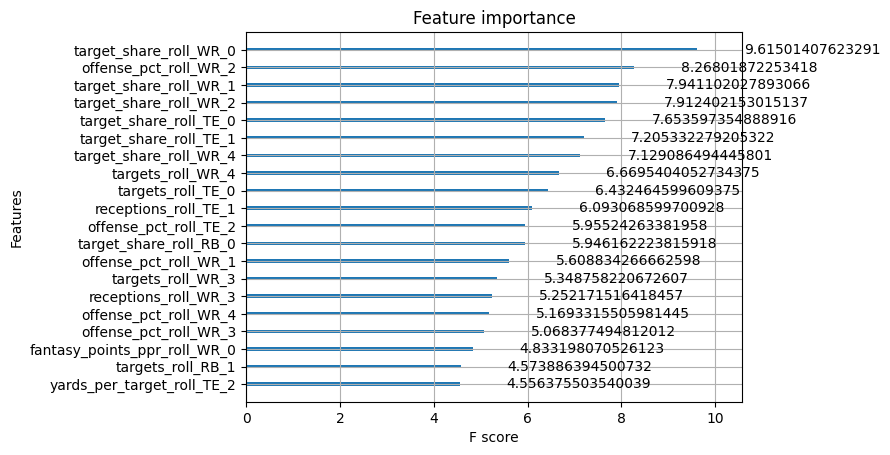

In [28]:
xgb.plot_importance(choose_receiver_model, importance_type="gain", max_num_features=20)

In [29]:
feature_config = {}
feature_config["receiver_idx_to_pos"] =  receiver_idx_to_pos
feature_config['choose_receiver_cols'] = choose_receiver_cols


In [30]:
feature_config.keys()

dict_keys(['receiver_idx_to_pos', 'choose_receiver_cols'])

In [31]:
update_config(feature_config)

In [32]:
player_context = [
    "season",
    'player_display_name',
    "team",
    "week",
    "gsis_id",
    "position",
]

In [33]:
receiver_cols = [
    "dense_depth",
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll']

receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')
receiver_stats[receiver_cols+player_context]

,dense_depth,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,season,player_display_name,team,week,gsis_id,position
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Geno Smith,NYJ,1,00-0030565,QB
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Cordarrelle Patterson,MIN,1,00-0030578,WR
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,DeAndre Hopkins,HOU,1,00-0030564,WR
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Ace Sanders,JAX,1,00-0030550,WR
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Tyler Eifert,CIN,1,00-0030549,TE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64419,0,3.405578e-20,7.959406e-07,-2.043347e-19,0.000000e+00,15.185686,4.000000,6.999994,11.633087,0.999969,2025,Matthew Stafford,LA,3,00-0026498,QB
64420,0,1.895721e-07,1.895721e-07,-7.598847e-07,0.000000e+00,16.407495,3.999998,6.999998,10.072956,0.947033,2025,Aaron Rodgers,PIT,3,00-0023459,QB
64421,2,2.432197e+00,3.717773e+00,2.854984e+01,1.475266e-01,6.549934,9.483676,7.535301,0.000000,0.722463,2025,Adam Thielen,MIN,3,00-0030035,WR
64422,0,2.514146e-06,2.514146e-06,2.514145e-06,8.054281e-18,18.616664,3.999992,6.999985,10.703586,0.980082,2025,Russell Wilson,NYG,3,00-0029263,QB


In [34]:
receiver_stats.iloc[5]

dense_depth                                       3
position                                         RB
gsis_id                                  00-0030547
game_id                              2013_01_KC_JAX
season                                         2013
week                                              1
player_id                                00-0030547
player_display_name                 Denard Robinson
team                                            JAX
opponent                                         KC
offense_snaps                                   6.0
offense_pct                                    0.08
receiving_air_yards_roll                        NaN
completions_roll                                NaN
fantasy_points_roll                             NaN
offense_snaps_roll                              NaN
passing_tds_roll                                NaN
target_share_roll                               NaN
passing_interceptions_roll                      NaN
passing_2pt_

In [35]:
qb_cols = [
    'dense_depth',
    "passing_yards_roll",
    "fantasy_points_ppr_roll",
    "sacks_suffered_roll",
    "passing_yards_after_catch_roll",
    "passing_interceptions_roll",
    "passing_tds_roll",
    "offense_pct_roll",
    "passing_air_yards_roll",
    "receiving_air_yards_roll",
    "passing_first_downs_roll",
    "sack_yards_lost_roll",
    "completion_pct_roll"
]
qb_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=qb_cols+player_context)
qb_stats.loc[qb_stats.player_display_name == 'Patrick Mahomes']

,dense_depth,passing_yards_roll,fantasy_points_ppr_roll,sacks_suffered_roll,passing_yards_after_catch_roll,passing_interceptions_roll,passing_tds_roll,offense_pct_roll,passing_air_yards_roll,receiving_air_yards_roll,passing_first_downs_roll,sack_yards_lost_roll,completion_pct_roll,season,player_display_name,team,week,gsis_id,position
25268,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,Patrick Mahomes,KC,17,00-0033873,QB
25840,0,284.000000,10.360000,2.000000,174.000000,1.000000,0.000000,0.940000,261.000000,0.000000,14.000000,-15.000000,0.628571,2018,Patrick Mahomes,KC,1,00-0033873,QB
26103,0,268.000000,20.634286,1.428571,139.142857,0.428571,2.285714,0.974286,312.428571,0.000000,11.714286,-6.428571,0.591549,2018,Patrick Mahomes,KC,2,00-0033873,QB
26364,0,293.081081,28.507027,1.243243,131.729730,0.243243,3.891892,0.985405,307.918919,0.000000,14.000000,-5.378378,0.686293,2018,Patrick Mahomes,KC,3,00-0033873,QB
26530,0,300.731429,27.319543,1.520000,149.382857,0.154286,3.565714,0.990743,335.742857,0.000000,14.365714,-5.971429,0.662919,2018,Patrick Mahomes,KC,4,00-0033873,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63412,0,236.573139,18.636878,1.983569,136.639378,0.133236,1.680912,0.988394,229.604590,-0.002523,12.170377,-12.144293,0.663161,2024,Patrick Mahomes,KC,21,00-0033873,QB
63439,0,238.679854,21.502659,1.987677,137.729534,0.099927,1.510684,0.991295,220.453443,-0.001892,12.627783,-12.108220,0.668901,2024,Patrick Mahomes,KC,22,00-0033873,QB
63493,0,243.259891,21.821994,2.990758,125.797150,0.574945,1.883013,0.993471,226.840082,-0.001419,12.220837,-16.831165,0.665811,2025,Patrick Mahomes,KC,1,00-0033873,QB
63919,0,246.944918,22.871495,2.743068,123.347863,0.431209,1.662260,0.995104,237.880062,-0.001064,11.415628,-14.873374,0.651484,2025,Patrick Mahomes,KC,2,00-0033873,QB


In [36]:
qb_stats.columns = [x + '_qb'  if x in qb_cols else x for x in qb_stats.columns]
qb_cols = [x + '_qb' for x in qb_cols]

In [37]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    qb_stats,
    left_on=["posteam", "season", "week", "passer_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
)
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
    suffixes=('_qb','')
)
passes

,play_id,game_id_qb,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_pct_roll,rushing_tds_roll,carries_roll,rushing_first_downs_roll,air_yards_share_roll,receiving_yards_roll,completion_pct_roll,yards_per_carry_roll,yards_per_catch_roll,yards_per_target_roll
0,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.470508,0.171469,10.091670,2.079055,0.012890,16.096828,NaN,5.020935,7.148195,5.395886
1,202.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,0.776022,0.000000,0.000000,0.000000,0.161831,36.062300,NaN,3.000000,8.401421,6.603948
2,230.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,0.420207,0.000000,0.671300,0.109330,0.038496,12.752543,NaN,3.668284,6.158952,5.642521
3,301.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,0.420207,0.000000,0.671300,0.109330,0.038496,12.752543,NaN,3.668284,6.158952,5.642521
4,412.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54350,3846.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,0.815882,0.000000,0.000000,0.000000,0.185711,33.349244,NaN,3.000000,9.374503,6.242714
54351,3871.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,0.332857,0.000000,3.857143,1.000000,-0.014539,27.428571,NaN,4.176471,6.666667,7.303030
54352,3950.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,0.573724,0.000000,0.307729,0.001198,0.090888,21.890127,NaN,3.286015,6.936673,5.523183
54353,3980.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,0.815882,0.000000,0.000000,0.000000,0.185711,33.349244,NaN,3.000000,9.374503,6.242714


In [38]:
completion_features = game_context_cols + qb_cols + receiver_cols + ['air_yards']
completion_features

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'dense_depth_qb',
 'passing_yards_roll_qb',
 'fantasy_points_ppr_roll_qb',
 'sacks_suffered_roll_qb',
 'passing_yards_after_catch_roll_qb',
 'passing_interceptions_roll_qb',
 'passing_tds_roll_qb',
 'offense_pct_roll_qb',
 'passing_air_yards_roll_qb',
 'receiving_air_yards_roll_qb',
 'passing_first_downs_roll_qb',
 'sack_yards_lost_roll_qb',
 'completion_pct_roll_qb',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll',
 'air_yards']

In [39]:
passes[completion_features]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,air_yards
0,59.0,1.0,0.0,10.0,0.0,0.0,869.0,1769.0,3569.0,NaN,...,1.811455,3.280451,16.096828,0.000000,9.650643,7.148195,5.395886,0.0,0.470508,0.0
1,72.0,1.0,0.0,10.0,0.0,0.0,822.0,1722.0,3522.0,NaN,...,3.768515,5.520690,36.062300,0.149017,8.268845,8.401421,6.603948,0.0,0.776022,-4.0
2,68.0,2.0,0.0,6.0,0.0,0.0,801.0,1701.0,3501.0,NaN,...,1.720031,2.500659,12.752543,0.030970,3.494453,6.158952,5.642521,0.0,0.420207,3.0
3,60.0,2.0,0.0,10.0,0.0,0.0,679.0,1579.0,3379.0,NaN,...,1.720031,2.500659,12.752543,0.030970,3.494453,6.158952,5.642521,0.0,0.420207,2.0
4,91.0,2.0,0.0,12.0,0.0,0.0,551.0,1451.0,3251.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54350,66.0,2.0,0.0,2.0,14.0,-7.0,127.0,127.0,127.0,NaN,...,2.984130,5.463414,33.349244,0.117472,7.023885,9.374503,6.242714,0.0,0.815882,6.0
54351,60.0,1.0,0.0,10.0,14.0,-7.0,120.0,120.0,120.0,NaN,...,3.714286,3.714286,27.428571,0.000000,8.185714,6.666667,7.303030,0.0,0.332857,0.0
54352,40.0,2.0,0.0,13.0,14.0,-7.0,85.0,85.0,85.0,NaN,...,2.732355,4.230703,21.890127,0.358270,7.200622,6.936673,5.523183,0.0,0.573724,5.0
54353,40.0,3.0,0.0,13.0,14.0,-7.0,81.0,81.0,81.0,NaN,...,2.984130,5.463414,33.349244,0.117472,7.023885,9.374503,6.242714,0.0,0.815882,12.0


In [40]:
def create_model(df, x_cols, y_col, colsample_bytree=0.5):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss", colsample_bytree=colsample_bytree)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    display(cm)
    return model

In [41]:
completion_df = passes.loc[~passes.offense_pct_roll.isna()].copy()[completion_features + ['complete_pass']]#.dropna()
#231174

In [42]:
complete_pass_model = create_model(
    completion_df, x_cols=completion_features, y_col="complete_pass", colsample_bytree=0.6
)
joblib.dump(complete_pass_model, "models/complete_pass.joblib")

Accuracy: 0.70
Confusion Matrix:


array([[1152, 2365],
       [ 815, 6375]])

['models/complete_pass.joblib']

In [43]:
feature_config = {
    "complete_pass_cols": completion_features,
}
feature_config

update_config(feature_config)

In [44]:
passes.loc[passes.air_yards > 40]['complete_pass'].value_counts(normalize=True)

complete_pass
0.0    0.720361
1.0    0.279639
Name: proportion, dtype: float64